In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

sys.path.append(os.path.abspath("../"))

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# import japanize_matplotlib
plt.style.use('ggplot')

import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import LogisticRegressionCV, LassoCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Simulation data
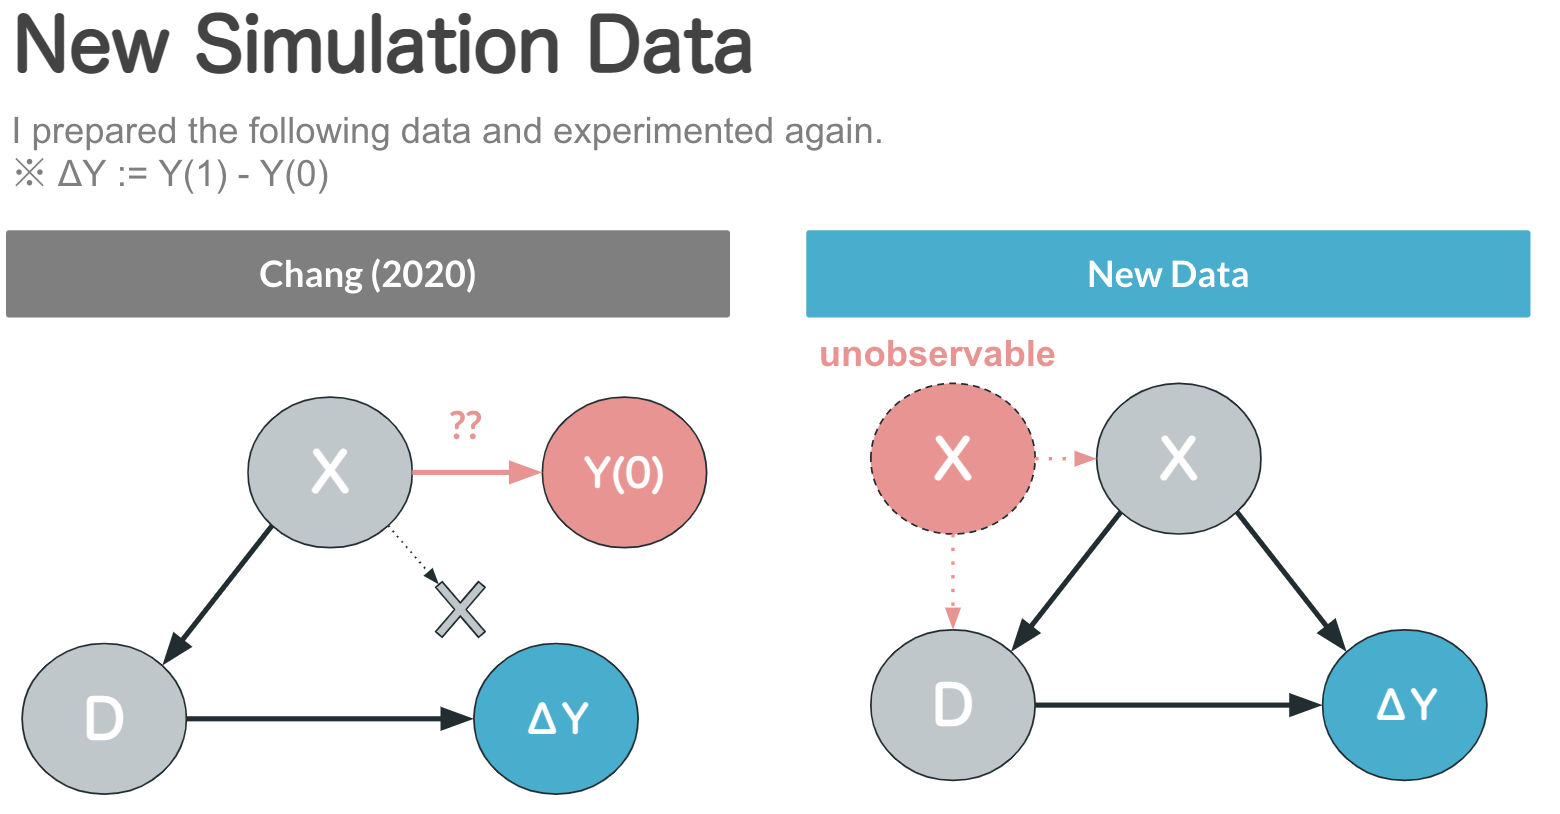

In [2]:
def true_delta(X, nonnull_cnt=8, base_seed=1):
    Xcolumns_cnt = X.shape[1]
    _i, _ii, _iii, _iiii = np.random.choice(Xcolumns_cnt, 4)
    np.random.seed(seed=base_seed)
    _coef = [
        np.random.normal(0, 4) if i <= nonnull_cnt else 0 for i in range(Xcolumns_cnt)
    ]
    z = (
        X.dot(_coef)
        + X[f"x{_i}"] * X[f"x{_ii}"] * 1
        + X[f"x{_iii}"] * X[f"x{_iiii}"] * 2
    )

    z = 1 / (1 + np.exp(-z))
    z = 0.5 * z * X["x4"]
    
    return z + np.random.normal(loc=0, scale=0.1, size=X.shape[0])

In [3]:
def generate_simdata(base_seed=1) -> pd.DataFrame:
    diff_model = LGBMRegressor(max_depth=10, random_state=base_seed)
    df_list = []
    N = 200
    cnt_subgroup = 10
    n_subgroup = int(N / cnt_subgroup)
    Xcolumns_cnt = 100
    true_att = 3

    for sg in range(cnt_subgroup):
        np.random.seed(seed=base_seed + sg)
        _x = []
        [
            _x.append(
                pd.DataFrame(
                    {
                        f"x{i}": np.random.normal(
                            loc=np.random.normal((sg+1) * i, 1), scale=0.1, size=n_subgroup
                        )
                    }
                )
            )
            for i in range(Xcolumns_cnt)
        ]

        X = pd.concat(_x, axis=1)
        X["x0"] = (sg+np.random.normal(loc=0, scale=2, size=n_subgroup)) * 0.11+ np.random.normal(loc=0, scale=0.1, size=n_subgroup)
        X["x1"] = 1/(sg+0.01) + np.random.normal(loc=0, scale=0.2, size=n_subgroup)
        X["x2"] = sg * np.random.normal(loc=0, scale=10, size=n_subgroup) + X["x1"]
        X["x3"] = np.exp(sg) + np.random.normal(loc=0, scale=0.1, size=n_subgroup)
        X["x4"] = -4 + sg +  np.random.normal(loc=0, scale=3, size=n_subgroup)
        X["x5"] = X["x4"]*X["x0"] + np.random.normal(loc=0, scale=5, size=n_subgroup)
        X["x6"] =  X["x3"]*X["x0"]  + np.random.normal(loc=0, scale=1, size=n_subgroup)

        _diff = true_delta(X, base_seed=base_seed)
        baseY = np.random.normal(
            loc=50,
            scale=10,
            size=n_subgroup,
        )
        Y = pd.DataFrame(
            {
                "Y_2020": baseY,
                "Y_2021": baseY + _diff,
                "Y_2022": baseY + _diff * 2,
                "Y_2023": baseY + _diff * 3,
            }
        )
        df = pd.concat([Y, X], axis=1)
        df["latent_group"] = sg
        df["latent_ps"] = np.clip(1- sg/10, 0.0001, 1- 0.1)
        df["D"] = df["latent_ps"].apply(lambda x: np.random.binomial(1, x))
        df_list.append(df)

    df = pd.concat(df_list).reset_index(drop=True)

    df["att_err"] = np.random.normal(
        loc=0,
        scale=1,
        size=N,
    )
    df["Y_2023"] = df.apply(
        lambda x: x["Y_2023"] + true_att + x["att_err"] if x["D"] > 0 else x["Y_2023"],
        axis=1,
    )
    del df["att_err"]
    return df.reset_index().rename(columns={"index": "unit_id"})

In [4]:
sample_df = generate_simdata(base_seed=0)
sample_df.sample(10).T

,149,147,192,131,136,162,107,13,170,133
unit_id,149.000000,147.000000,192.000000,131.000000,136.000000,162.000000,107.000000,13.000000,170.000000,133.000000
Y_2020,46.126732,62.302907,35.799821,39.514470,45.619257,53.781625,62.302907,32.937298,46.976972,32.937298
Y_2021,48.552146,61.418987,37.729432,38.872804,47.019186,55.542649,60.676219,30.573736,46.810804,35.386472
Y_2022,50.977560,60.535067,39.659043,38.231138,48.419115,57.303673,59.049532,28.210175,46.644636,37.835645
Y_2023,53.402974,59.651148,44.269326,37.589472,49.819045,59.064696,57.422844,29.248954,48.985147,43.808096
...,...,...,...,...,...,...,...,...,...,...
x98,783.208201,783.236989,978.875420,685.972362,685.677311,883.715079,588.032170,98.257397,883.824858,685.850158
x99,792.523432,792.540142,991.584568,692.452858,692.433648,888.944089,593.916854,99.701675,888.858910,692.456584
latent_group,7.000000,7.000000,9.000000,6.000000,6.000000,8.000000,5.000000,0.000000,8.000000,6.000000
latent_ps,0.300000,0.300000,0.100000,0.400000,0.400000,0.200000,0.500000,0.900000,0.200000,0.400000


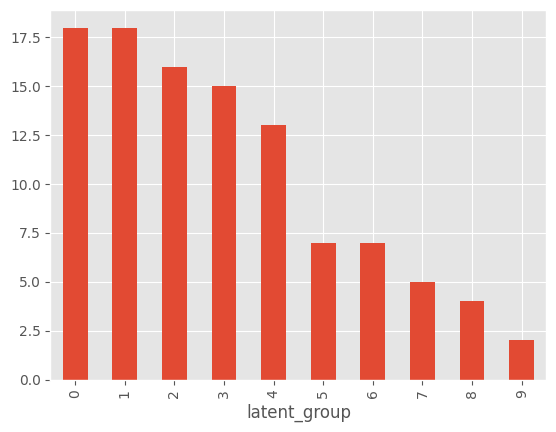

In [5]:
sample_df.groupby("latent_group")["D"].sum().plot(kind="bar")
plt.show()

## No Paralle Trend

In [6]:
melt_df = pd.melt(sample_df,id_vars=["unit_id","latent_group", "D"],value_vars=["Y_2020", "Y_2021", "Y_2022", "Y_2023"],value_name="Y" )
melt_df["year"] = melt_df["variable"].str.replace("Y_","").astype(int)
melt_df = melt_df.sort_values(["unit_id", "year"])

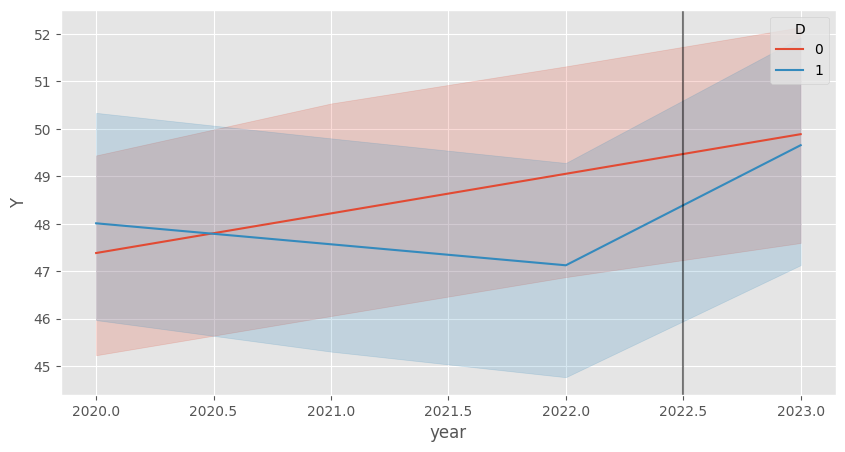

In [7]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
sns.lineplot(x="year", y="Y", hue="D",  data=melt_df, ax=ax)
ax.axvline(x=2022.5, alpha=0.5, color = "black")
plt.show()

## Conditional parallel trend

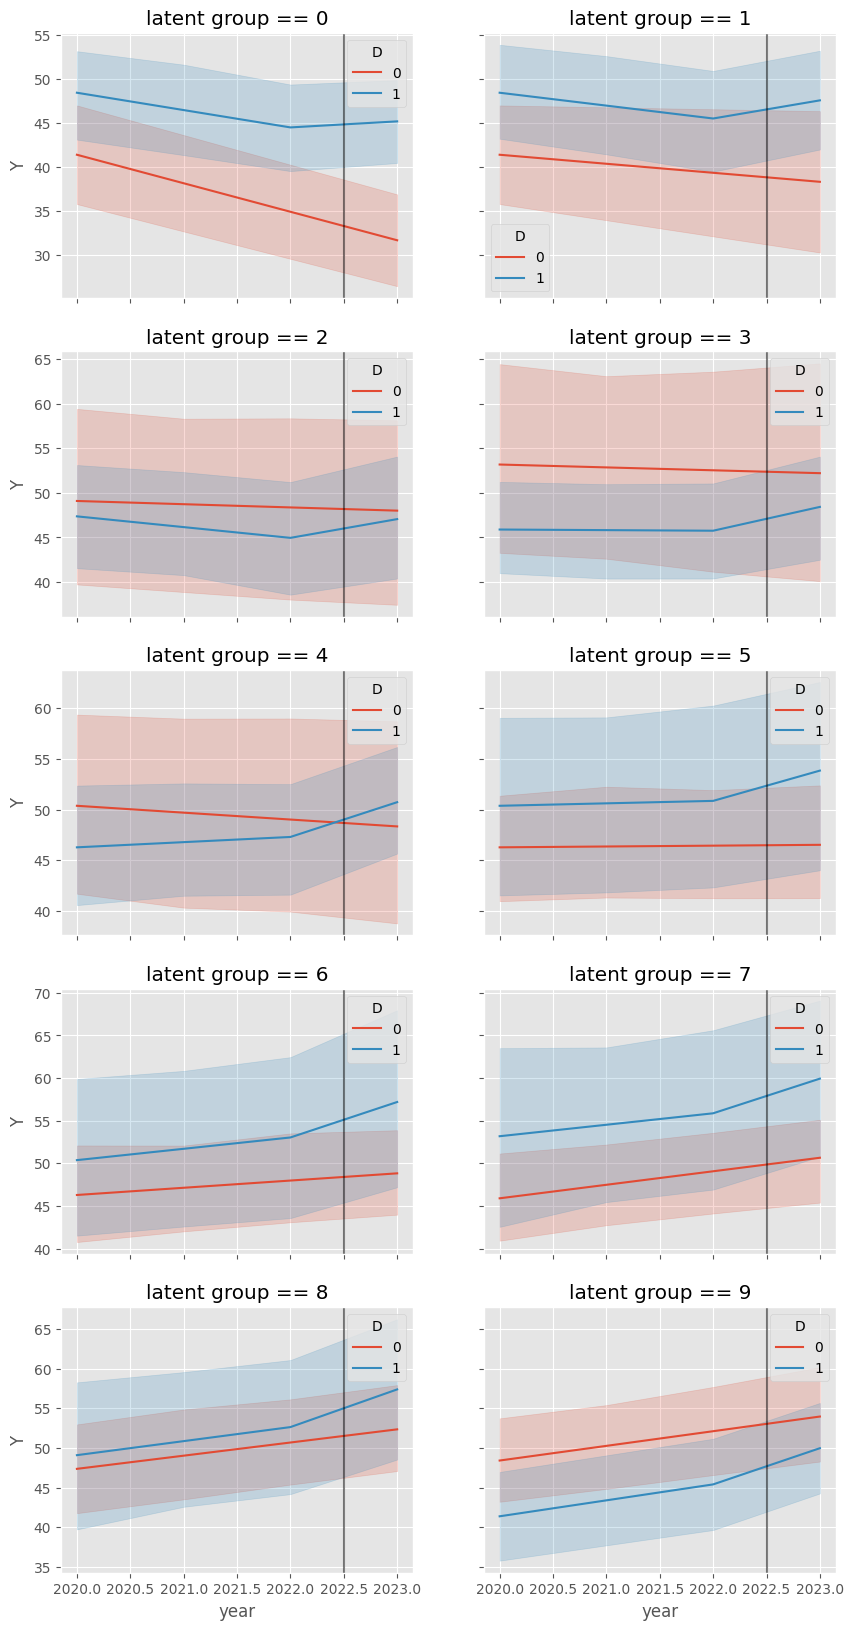

In [8]:
fig, ax = plt.subplots(5, 2, sharex='col', sharey='row', figsize=(10,20))
ax = ax.ravel() 
latent_group_cnt = 10
for lg in range(latent_group_cnt):
    _sub_df = melt_df.query("latent_group == @lg")
    sns.lineplot(x="year", y="Y", hue="D",  data=_sub_df, ax=ax[lg])
    ax[lg].axvline(x=2022.5, alpha=0.5, color = "black")
    ax[lg].set_title(f"latent group == {lg}")
plt.show()

In [9]:
y1_col = "Y_2023"
y0_col = "Y_2022"
d_col = "D"
X_cols = [f"x{i}" for i in range(100)]

In [10]:
def naive_did(
    df,
    y1_col,
    y0_col,
    d_col,
) -> np.float:
    _pivot = df.groupby(d_col)[[y0_col, y1_col]].mean()
    _pivot["diff"] = _pivot.diff(axis=1)[y1_col]
    return _pivot["diff"].diff().values[-1]

In [11]:
print("naive_did : ", naive_did(sample_df, y1_col, y0_col, d_col))

naive_did :  1.696927981914179


In [12]:
SIM_CNT = 500  # 500
sim_df = {}
for i in tqdm(range(SIM_CNT)):
    sim_df[i] = generate_simdata(base_seed=i)
    assert sim_df[i].isnull().sum().sum() == 0

100%|██████████| 500/500 [04:16<00:00,  1.95it/s]


In [13]:
naive_did_result = []

for i in tqdm(range(SIM_CNT)):
    naive_did_result.append(naive_did(sim_df[i], y1_col, y0_col, d_col))

100%|██████████| 500/500 [00:02<00:00, 181.54it/s]


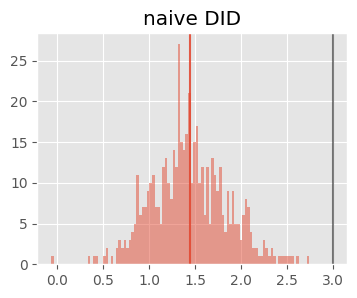

1.438927799961004


In [14]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(4,3))
ax.hist(naive_did_result, bins=100, alpha=0.5)

ax.set_title("naive DID")
ax.axvline(x=3, alpha=0.5, color = "black")
ax.axvline(x=np.mean(naive_did_result), alpha=0.9)
plt.show()
print(np.mean(naive_did_result))

## Abadie (2005)

In [15]:
def semiparametricDID(
    df,
    y1_col,
    y0_col,
    d_col,
    X_cols,
    ps_model=LogisticRegressionCV(cv=5, random_state=333, penalty="l1", solver="saga"),
) -> np.float:

    ps_model.fit(df[X_cols], df[d_col])
    eps = 0.03
    ghat = np.clip(
        ps_model.predict_proba(df[X_cols])[:, 1],
        eps,
        1 - eps,
    )
    
    mean_d = df[d_col].mean()
    return (
        (df[y1_col] - df[y0_col]) / mean_d * (df[d_col] - ghat) / (1 - ghat)
    ).mean()

## DMLDiD

In [16]:
def dmldid_rc(
    df,
    y1_col,
    y0_col,
    d_col,
    X_cols,
    ps_model=LogisticRegressionCV(cv=5, random_state=333, penalty="l1", solver="saga"),
    l1k_model=LassoCV(cv=5, random_state=333),
    cap=False
) -> np.float:
    
    if cap:
        diff = df[y1_col] - df[y0_col]
        _min = diff.min()
        _max = diff.max()

    K = 2  
    df_set = train_test_split(df, random_state=0, test_size=0.5)
    thetabar = []
    for i in range(K):
        k = 0 if i == 0 else 1
        c = 1 if i == 0 else 0

        ps_model.fit(df_set[c][X_cols], df_set[c][d_col])

        eps = 0.03
        ghat = np.clip(
            ps_model.predict_proba(df_set[k][X_cols])[:, 1],
            eps,
            1 - eps,
        )

        control_y0 = df_set[c].query(f"{d_col} < 1")[y0_col]
        control_y1 = df_set[c].query(f"{d_col} < 1")[y1_col]
        _y = control_y1 - control_y0
        control_x = df_set[c].query(f"{d_col} < 1")[X_cols]

        l1k_model.fit(control_x, _y)
        l1hat = l1k_model.predict(df_set[k][X_cols])
        
        if cap:
            l1hat = np.clip(l1hat, _min, _max)

        p_hat = df_set[c][d_col].mean()
        
        _e = (
            (df_set[k][y1_col] - df_set[k][y0_col] - l1hat)
            / p_hat
            * (df_set[k][d_col] - ghat)
            / (1 - ghat)
        ).mean()
    
        thetabar.append(_e)
    return np.mean(thetabar)

In [17]:
semiparametricDID(
    sim_df[0],
    y1_col,
    y0_col,
    d_col,
    X_cols,
    ps_model=LGBMClassifier(max_depth=10, random_state=0),
)

2.52089995311462

In [18]:
dmldid_rc(
    sim_df[0],
    y1_col,
    y0_col,
    d_col,
    X_cols,
    ps_model=LGBMClassifier(max_depth=10, random_state=0),
    l1k_model=LGBMRegressor(max_depth=10, random_state=0),
    cap=True
)

3.467017972228522

In [19]:
dmldid_lasso = []
abadie_lasso = []
dmldid_lgbm = []
abadie_lgbm = []

In [20]:
for i in tqdm(range(SIM_CNT)):
    # lasso
    abadie_lasso.append(semiparametricDID(sim_df[i], y1_col, y0_col, d_col, X_cols))
    dmldid_lasso.append(dmldid_rc(sim_df[i], y1_col, y0_col, d_col, X_cols))

    # lgbm
    # For reference on usage.
    # No hyperparameter tuning, so I don't trust the results.
    abadie_lgbm.append(
        semiparametricDID(
            sim_df[i],
            y1_col,
            y0_col,
            d_col,
            X_cols,
            ps_model=LGBMClassifier(max_depth=10, random_state=0),
        )
    )
    dmldid_lgbm.append(
        dmldid_rc(
            sim_df[i],
            y1_col,
            y0_col,
            d_col,
            X_cols,
            ps_model=LGBMClassifier(max_depth=10, random_state=0),
            l1k_model=LGBMRegressor(max_depth=10, random_state=0),
        )
    )

100%|██████████| 500/500 [27:47<00:00,  3.34s/it]


In [21]:
result_df = pd.DataFrame(
    {
        "abadie_lasso": abadie_lasso,
        "abadie_lgbm": abadie_lgbm,
        "dmldid_lasso": dmldid_lasso,
        "dmldid_lgbm": dmldid_lgbm,
    }
)

In [22]:
result_df.describe()

,abadie_lasso,abadie_lgbm,dmldid_lasso,dmldid_lgbm
count,500.000000,500.000000,500.000000,500.000000
mean,2.215479,2.501303,2.958643,3.538918
std,0.271652,0.241317,0.289226,1.078260
min,1.203484,1.716487,0.719568,0.939591
25%,2.024616,2.338952,2.804684,2.825557
50%,2.209419,2.502340,2.985683,3.409141
75%,2.389169,2.655182,3.128567,4.074780
max,3.105527,3.239029,4.229837,10.229177


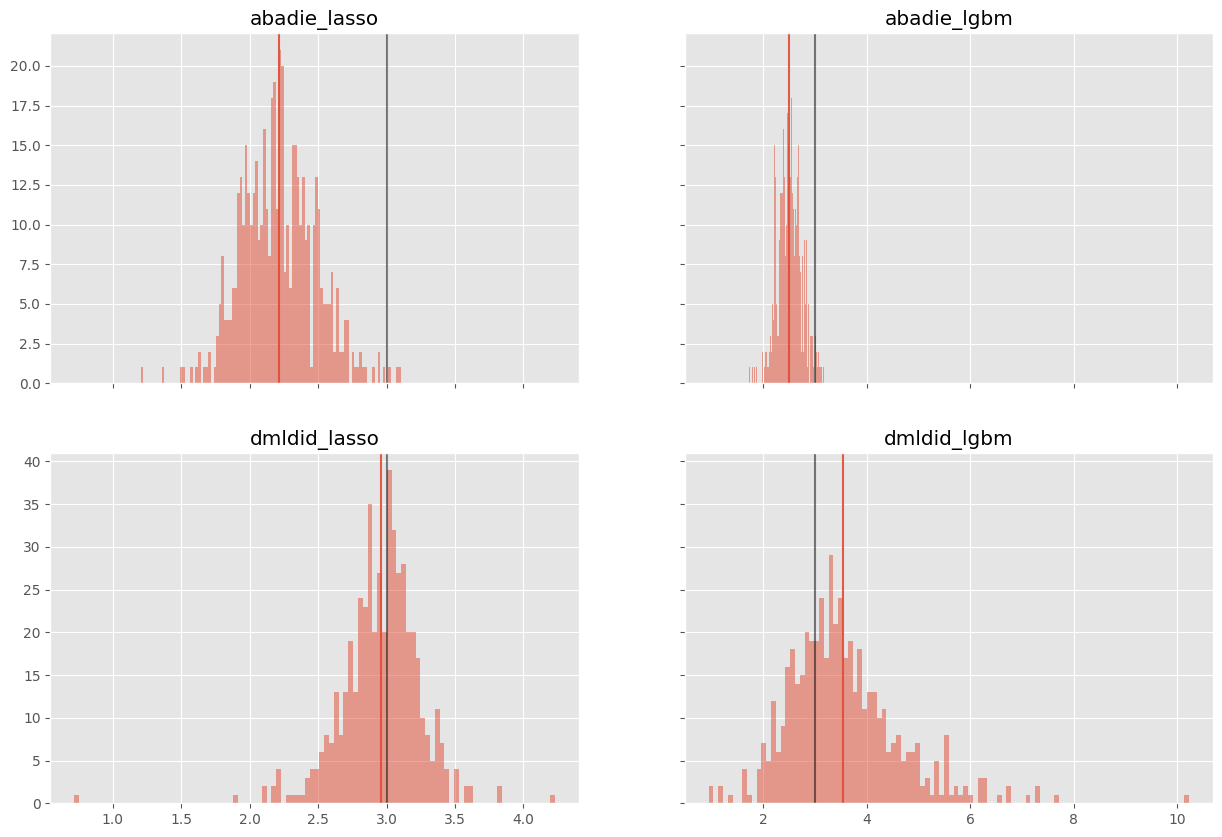

In [23]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(15,10))
ax = ax.ravel() 
for i, _col in enumerate(result_df.columns):
    ax[i].hist(result_df[_col], bins=100, alpha=0.5)
    #ax[i].set_xlim(2,4)
    ax[i].set_title(_col)
    ax[i].axvline(x=3, alpha=0.5, color = "black")
    ax[i].axvline(x=result_df[_col].mean(), alpha=0.9)
plt.show()

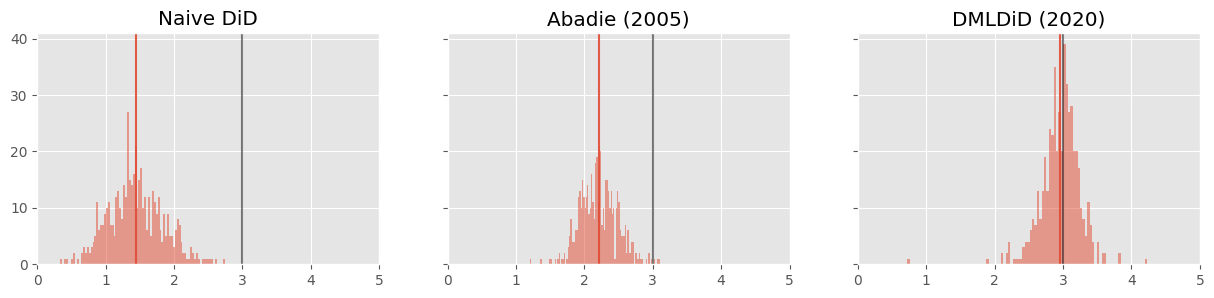

In [24]:
_label = ["Naive DiD", "Abadie (2005)", "DMLDiD (2020)"]
result_df = pd.DataFrame(
    {
        "naive_did":naive_did_result,
        "abadie_lasso": abadie_lasso,
        "dmldid_lasso": dmldid_lasso,    
    }
)
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,3))
ax = ax.ravel() 
for i, _col in enumerate(result_df.columns):
    ax[i].hist(result_df[_col], bins=100, alpha=0.5)
    ax[i].set_xlim(0,5)
    ax[i].set_title(_label[i])
    ax[i].axvline(x=3, alpha=0.5, color = "black")
    ax[i].axvline(x=result_df[_col].mean(), alpha=0.9)
plt.show()

In [25]:
result_df.describe().T

,count,mean,std,min,25%,50%,75%,max
naive_did,500.0,1.438928,0.408639,-0.061256,1.173433,1.415792,1.705225,2.738565
abadie_lasso,500.0,2.215479,0.271652,1.203484,2.024616,2.209419,2.389169,3.105527
dmldid_lasso,500.0,2.958643,0.289226,0.719568,2.804684,2.985683,3.128567,4.229837
